In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,
                                          Nystroem)
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
# The digits dataset
digits = datasets.load_digits(n_class=9)

In [3]:
# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.data)
data = digits.data / 16.
data -= data.mean(axis=0)

In [4]:
# We learn the digits on the first half of the digits
data_train, targets_train = (data[:n_samples // 2],
                             digits.target[:n_samples // 2])


# Now predict the value of the digit on the second half:
data_test, targets_test = (data[n_samples // 2:],
                           digits.target[n_samples // 2:])
# data_test = scaler.transform(data_test)

In [5]:
# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()

Código propio: añado un DecisionTree sin ninguna aproximación de kernel

In [6]:
simply_dt = DecisionTreeClassifier()

In [7]:
non_overfitting_dt = DecisionTreeClassifier(min_samples_leaf=5,
                                            max_depth = 50,
                                            min_samples_split = 10,
                                            min_impurity_decrease = 0.01)

In [8]:
logit = LogisticRegression( C = 1e30, multi_class = 'multinomial', solver = 'lbfgs')
# El solver por defecto no hace multinomial, solo "one-versus-rest"
# C muy grande para minimizar la regularización

In [9]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2))
# Dos capas ocultas, la primera con 5 neuronas, la segunda con 2

In [10]:
# create pipeline from kernel approximation
# and linear svm
feature_map_fourier = RBFSampler(gamma=.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=.2, random_state=1)

In [11]:
fourier_approx_svm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", svm.LinearSVC())])

nystroem_approx_svm = pipeline.Pipeline([("feature_map", feature_map_nystroem),
                                        ("svm", svm.LinearSVC())])

Código propio: hago el pipeline con un DecisionTree
Nota: de momento uso el mismo RBFSampler que usan ellos, la misma instancia. Si afecta puedo usar uno nuevo. No lo creo

In [12]:
fourier_approx_dt = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                       ("dt", DecisionTreeClassifier())])

In [13]:
fourier_approx_logit = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                       ("logit", LogisticRegression( C = 1e30,
                                                                     multi_class = 'multinomial',
                                                                     solver = 'lbfgs'))])

In [14]:
# fit and predict using linear and kernel svm:

kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time

Código propio: hago lo mismo con el DT él solo

In [15]:
simply_dt_time = time()
simply_dt.fit(data_train, targets_train)
simply_dt_score = simply_dt.score(data_test, targets_test)
simply_dt_time = time() - simply_dt_time

Lo de abajo es solo por probar, hay que borrarlo

In [16]:
gg = simply_dt.decision_path(data_train)

In [17]:
len(gg[0,:].toarray()[0])

163

Código propio: hago lo mismo con logit

In [18]:
logit_time = time()
logit.fit(data_train, targets_train)
logit_score = logit.score(data_test, targets_test)
logit_time = time() - logit_time

Código propio: hago lo mismo con mlp

In [19]:
mlp_time = time()
mlp.fit(data_train, targets_train)
mlp_score = mlp.score(data_test, targets_test)
mlp_time = time() - mlp_time

Código propio: hago lo mismo con non_overfitting_dt

In [20]:
non_overfitting_dt_time = time()
non_overfitting_dt.fit(data_train, targets_train)
non_overfitting_dt_score = non_overfitting_dt.score(data_test, targets_test)
non_overfitting_dt_time = time() - non_overfitting_dt_time

In [21]:
sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

Código propio: hago las listas para mi nuevo modelo.
Nota: ellos usan un nombre ambiguo. Les llaman fourier_scores y fourier_times porque solamente la svm usa fourier. Nosotros usamos fourier con dt.

In [22]:
fourier_dt_scores = []
fourier_dt_times = []

In [23]:
fourier_logit_scores = []
fourier_logit_times = []

In [24]:
for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    
    ##Código propio: lo mismo con mi pipeline
    fourier_approx_dt.set_params(feature_map__n_components=D)
    fourier_approx_logit.set_params(feature_map__n_components=D)
    
    #Nystroem svm
    start = time()
    nystroem_approx_svm.fit(data_train, targets_train)
    nystroem_times.append(time() - start)

    # Fourier svm
    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)
    
    # Código propio: el tiempo del fourier dt y del fourier logit
    start = time()
    fourier_approx_dt.fit(data_train, targets_train)
    fourier_dt_times.append(time() - start)
    
    start = time()
    fourier_approx_logit.fit(data_train, targets_train)
    fourier_logit_times.append(time() - start)

    # Cálculo de scores
    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test, targets_test)
    
    # Código propio: calculo sl score con mi pipeline
    fourier_dt_score = fourier_approx_dt.score(data_test, targets_test)
    fourier_logit_score = fourier_approx_logit.score(data_test, targets_test)
    
    
    # Poner los scores en las listas de score
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)
    
    # Código propio: pongo mis propios scores y times
    fourier_dt_scores.append(fourier_dt_score)
    fourier_logit_scores.append(fourier_logit_score)

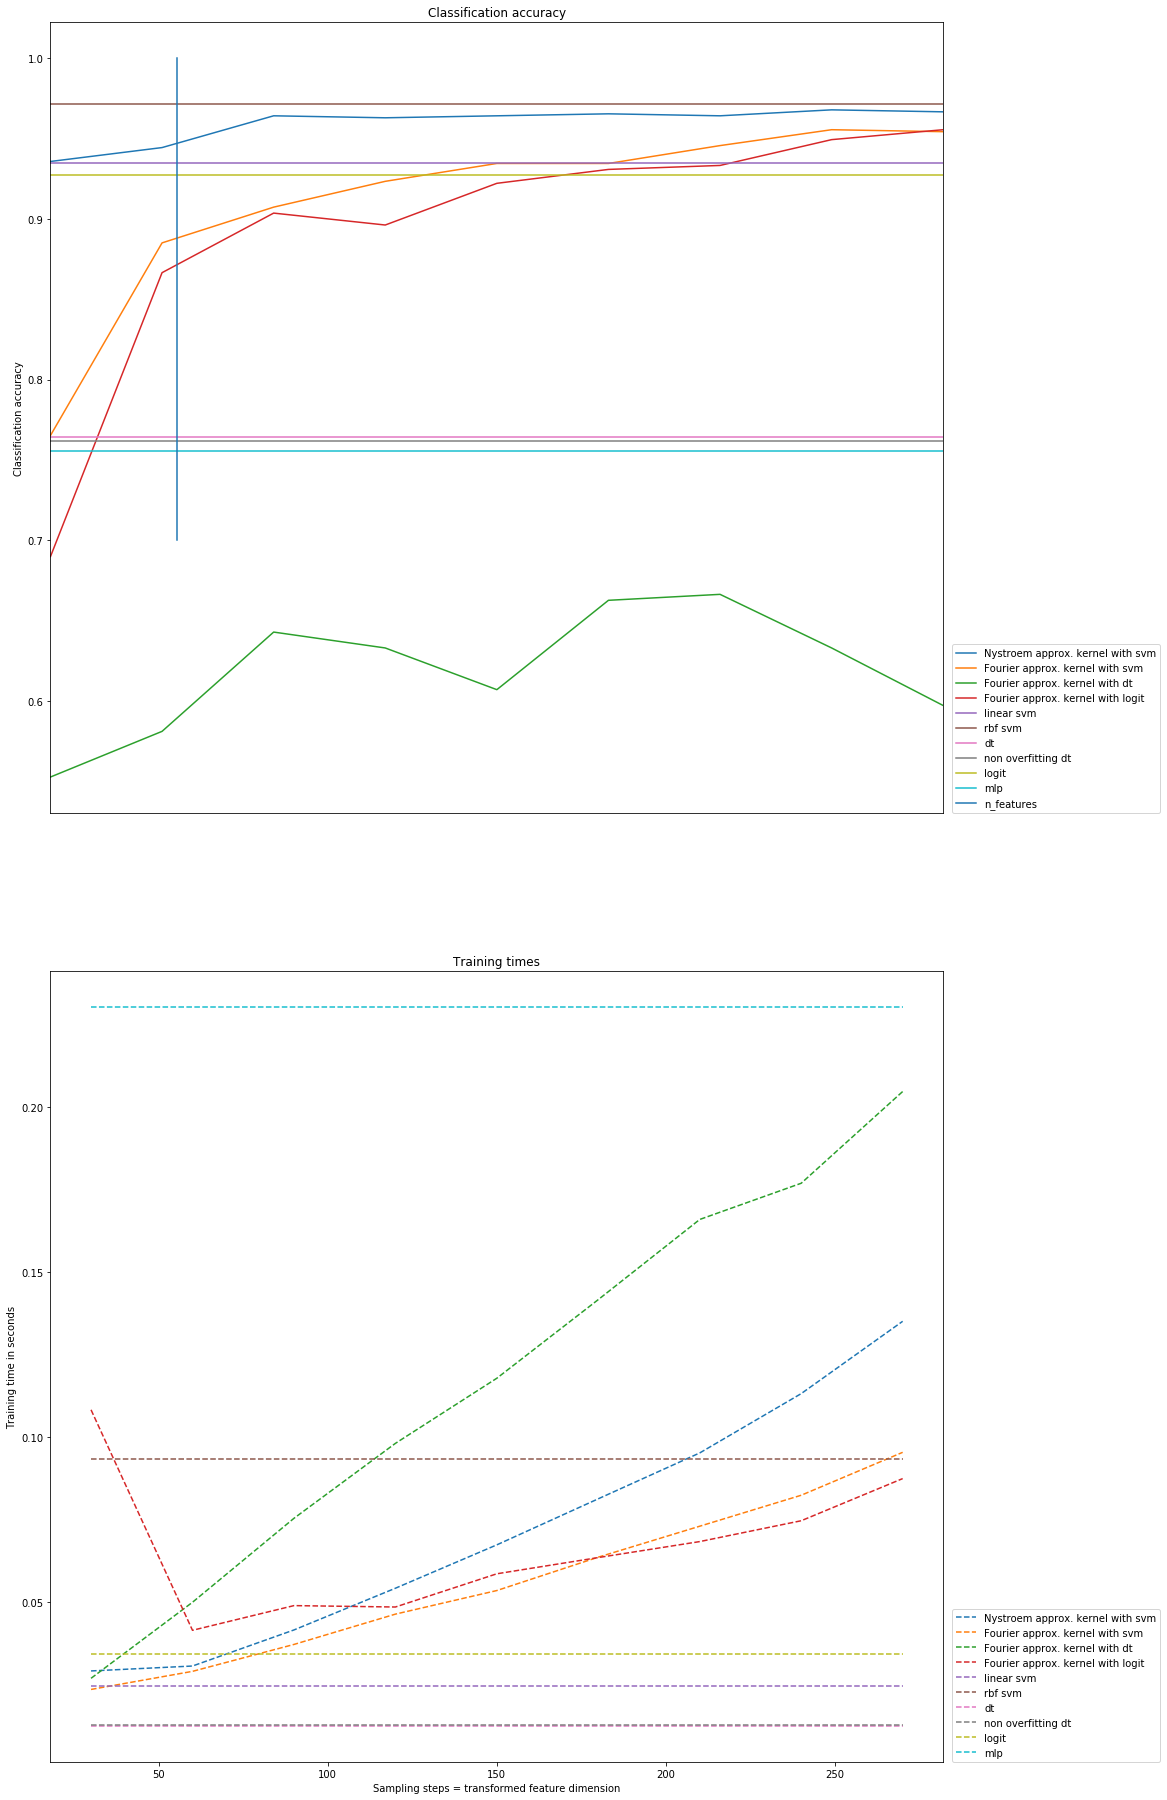

In [25]:
# plot the results:
plt.figure(figsize=(16, 32))
accuracy = plt.subplot(211)
# second y axis for timeings
timescale = plt.subplot(212)

# Accuracy y tiempo de nystroem
accuracy.plot(sample_sizes, nystroem_scores,
              label="Nystroem approx. kernel with svm")
timescale.plot(sample_sizes, nystroem_times, '--',
               label='Nystroem approx. kernel with svm')

# Accuracy y tiempo de fourier svm
accuracy.plot(sample_sizes, fourier_scores, 
              label="Fourier approx. kernel with svm")
timescale.plot(sample_sizes, fourier_times, '--',
               label='Fourier approx. kernel with svm')

# Accuracy y tiempo de fourier dt
accuracy.plot(sample_sizes, fourier_dt_scores,
              label="Fourier approx. kernel with dt")
timescale.plot(sample_sizes, fourier_dt_times, '--',
               label='Fourier approx. kernel with dt')

# Accuracy y tiempo de fourier logit
accuracy.plot(sample_sizes, fourier_logit_scores,
              label="Fourier approx. kernel with logit")
timescale.plot(sample_sizes, fourier_logit_times, '--',
               label='Fourier approx. kernel with logit')

# -------------------------------------------------
# Aquí empiezan las horizontales
# ----------------------------------------

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="linear svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_svm_time, linear_svm_time], '--', label='linear svm')


accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

# Código propio: lo mismo, las lineas horizontales para el DT simple
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [simply_dt_score, simply_dt_score], label="dt")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [simply_dt_time, simply_dt_time], '--', label='dt')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [non_overfitting_dt_score, non_overfitting_dt_score], label="non overfitting dt")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [non_overfitting_dt_time, non_overfitting_dt_time], '--', label='non overfitting dt')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [logit_score, logit_score], label="logit")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [logit_time, logit_time], '--', label='logit')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [mlp_score, mlp_score], label="mlp")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [mlp_time, mlp_time], '--', label='mlp')


# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
#accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc=(1.01,0)) # Modifico la posición de la leyenda, que no se ve bien
timescale.legend(loc=(1.01,0))

Nota: observo que el accuracy de MLP oscila mucho. A veces genial, otras fatal. Creo que es normal

## Repito las gráficas para que se vean mejor

### Solamente las aproximaciones

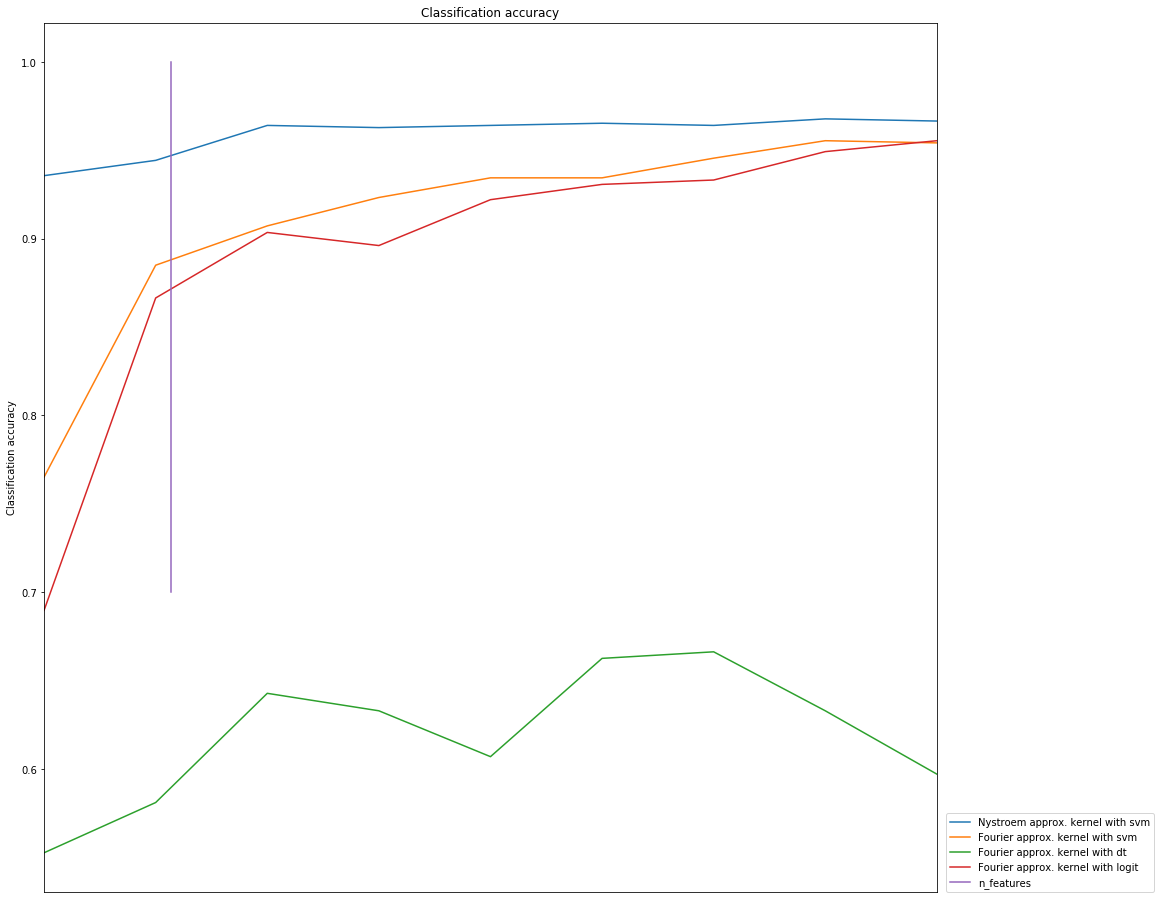

In [26]:
# plot the results:
plt.figure(figsize=(16, 16))
accuracy = plt.subplot(111)
# second y axis for timeings


# Accuracy y tiempo de nystroem
accuracy.plot(sample_sizes, nystroem_scores,
              label="Nystroem approx. kernel with svm")

# Accuracy y tiempo de fourier svm
accuracy.plot(sample_sizes, fourier_scores, 
              label="Fourier approx. kernel with svm")


# Accuracy y tiempo de fourier dt
accuracy.plot(sample_sizes, fourier_dt_scores,
              label="Fourier approx. kernel with dt")


# Accuracy y tiempo de fourier logit
accuracy.plot(sample_sizes, fourier_logit_scores,
              label="Fourier approx. kernel with logit")


# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")

accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
#accuracy.set_ylim(np.min(fourier_scores), 1)

accuracy.set_ylabel("Classification accuracy")

accuracy.legend(loc=(1.01,0)) # Modifico la posición de la leyenda, que no se ve bien

### Recortando las lineas horizontales

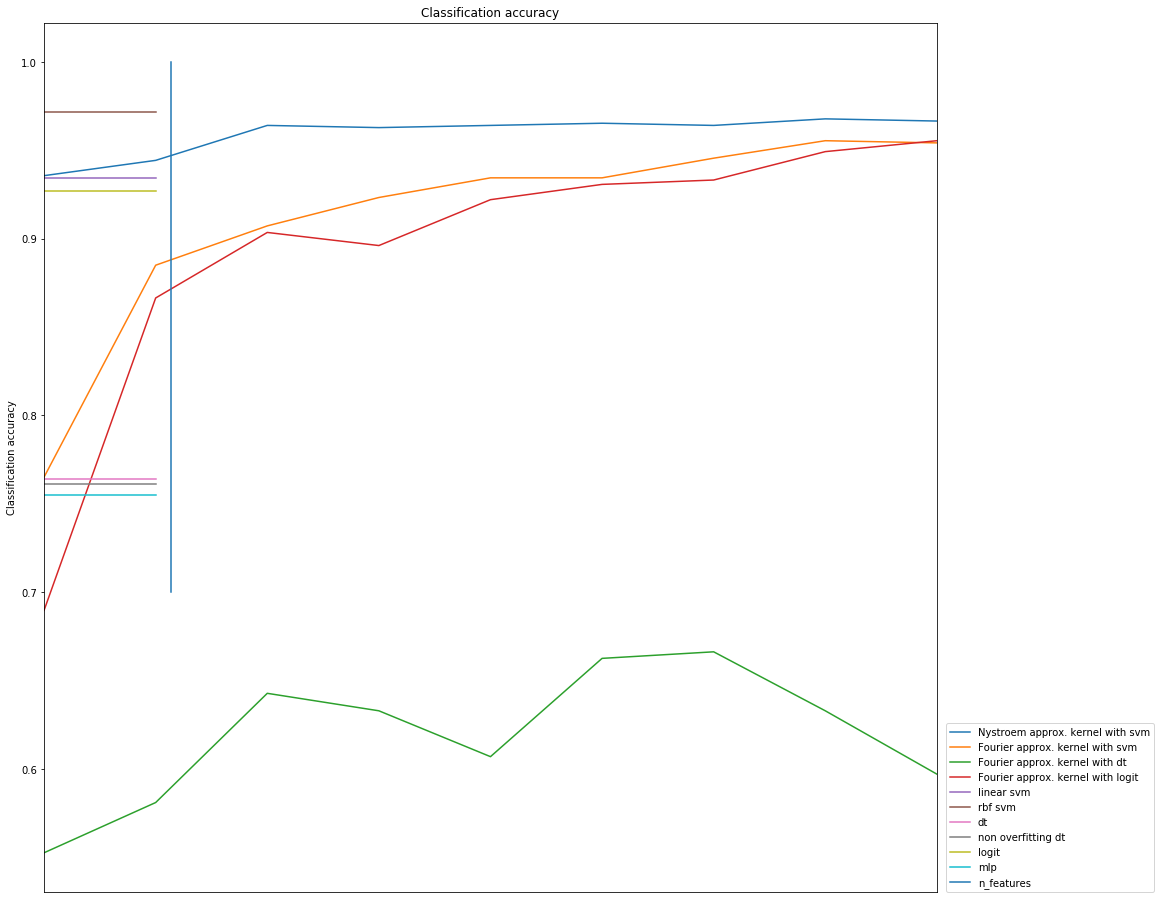

In [27]:
# plot the results:
plt.figure(figsize=(16, 16))
accuracy = plt.subplot(111)
# second y axis for timeings


# Accuracy y tiempo de nystroem
accuracy.plot(sample_sizes, nystroem_scores,
              label="Nystroem approx. kernel with svm")

# Accuracy y tiempo de fourier svm
accuracy.plot(sample_sizes, fourier_scores, 
              label="Fourier approx. kernel with svm")


# Accuracy y tiempo de fourier dt
accuracy.plot(sample_sizes, fourier_dt_scores,
              label="Fourier approx. kernel with dt")


# Accuracy y tiempo de fourier logit
accuracy.plot(sample_sizes, fourier_logit_scores,
              label="Fourier approx. kernel with logit")


# -------------------------------------------------
# Aquí empiezan las horizontales
# ----------------------------------------

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], sample_sizes[len(sample_sizes) // 5]],
              [linear_svm_score, linear_svm_score], label="linear svm")



accuracy.plot([sample_sizes[0], sample_sizes[len(sample_sizes) // 5]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm")


# Código propio: lo mismo, las lineas horizontales para el DT simple
accuracy.plot([sample_sizes[0], sample_sizes[len(sample_sizes) // 5]],
              [simply_dt_score, simply_dt_score], label="dt")


accuracy.plot([sample_sizes[0], sample_sizes[len(sample_sizes) // 5]],
              [non_overfitting_dt_score, non_overfitting_dt_score], label="non overfitting dt")


accuracy.plot([sample_sizes[0], sample_sizes[len(sample_sizes) // 5]],
              [logit_score, logit_score], label="logit")


accuracy.plot([sample_sizes[0], sample_sizes[len(sample_sizes) // 5]],
              [mlp_score, mlp_score], label="mlp")



# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")

accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
#accuracy.set_ylim(np.min(fourier_scores), 1)

accuracy.set_ylabel("Classification accuracy")

accuracy.legend(loc=(1.01,0)) # Modifico la posición de la leyenda, que no se ve bien
